### Assignment 2

#### Submit your assignment as .ipynb

In [43]:
import math
from enum import Enum
from scipy.interpolate import CubicSpline
import numpy as np
import matplotlib.pyplot as plt
import bisect
import seaborn as sns
from scipy.stats import norm
from scipy import optimize

In [44]:
class PayoffType(Enum):
    Call = 0
    Put = 1
    BinaryCall = 2
    BinaryPut = 3

In [45]:
class EuropeanOption():
    def __init__(self, expiry, strike, payoffType):
        self.expiry = expiry
        self.strike = strike
        self.payoffType = payoffType
        
    def payoff(self, S):
        if self.payoffType == PayoffType.Call:
            return max(S - self.strike, 0)
        elif self.payoffType == PayoffType.Put:
            return max(self.strike - S, 0)
        elif self.payoffType == PayoffType.BinaryCall:
            if S > self.strike:
                return 1.0
            else:
                return 0.0
        elif self.payoffType == PayoffType.BinaryPut:
            if S < self.strike:
                return 1.0
            else:
                return 0.0
        else:
            raise Exception("payoffType not supported: ", self.payoffType)
            
    def valueAtNode(self, t, S, continuation):
        if continuation == None:
            return self.payoff(S)
        else:
            return continuation

In [46]:
def cnorm(x):
    return (1.0 + math.erf(x / math.sqrt(2.0))) / 2.0

In [47]:
def bsPrice(S, r, q, vol, trade):
    fwd = S * math.exp((r - q) * trade.expiry)
    stdev = vol * math.sqrt(trade.expiry)
    d1 = math.log(fwd / trade.strike) / stdev + stdev / 2
    d2 = d1 - stdev
    
    if trade.payoffType == PayoffType.Call:
        return math.exp(-r * trade.expiry) * (fwd * cnorm(d1) - cnorm(d2) * trade.strike)
    elif trade.payoffType == PayoffType.Put:
        return math.exp(-r * trade.expiry) * (trade.strike * cnorm(-d2) - cnorm(-d1) * fwd)
    elif trade.payoffType == PayoffType.BinaryCall:
        return math.exp(-r * trade.expiry) * cnorm(d1)
    elif trade.payoffType == PayoffType.BinaryPut:
        return math.exp(-r * trade.expiry) * (1 - cnorm(-d1))
    else:
        raise Exception("not supported payoff type", payoffType)

#### Exercise 1.

Implement a trinomial tree that takes the below signature:

```def trinomialPricerAnchor(S, r, q, vol, trade, n, K):```

Instead of taking the parameter $\lambda$ in our example code, this function takes a discontinuity K and anchors a tree node to K by tuning $\lambda$ inside the pricer.
Note that there are many ways to adjust $\lambda$, one example is to construct the tree with $\lambda = \sqrt{3}$ first, find the node closest to $K$, then adjust $\lambda$ such that the node falls on $K$, but you are free to define your own way to achieve this.

Plot the pricing errors of this trinomial tree pricer with the market and strike below, for number of tree steps from 10 to 300 (similar to our binomial tree test cases).
Use a European Call option and a Binary Call option as test trades.

In [92]:
eurocall = EuropeanOption (1, 105, PayoffType.Call)

In [93]:
binarycall = EuropeanOption (1, 105, PayoffType.BinaryCall)

In [94]:
def trinomialPricerAnchor(S, r, q, vol, trade, n, K):
    
    lmda = math.sqrt(3) # initial lambda for start 
    t = trade.expiry / n
    u = math.exp(lmda * vol * math.sqrt(t)) # our lambda dependent step
    mu = r - q # our drift
    vs_1 = [(S * u ** (n - i)) for i in range(2*n + 1)]
    vs_k = [abs(i - K) for i in vs_1]
    
    nod = vs_k.index(min(vs_k)) # check closeness to strike
    if nod != n:
        lmda = (math.log(K/S))/(n-nod) / vol / math.sqrt(t)
    elif nod == n:
        lmda = math.sqrt(3)
    u = math.exp(lmda * vol * math.sqrt(t))
    pu = 1 / 2 / lmda / lmda + (mu - vol * vol / 2) / 2 / lmda / vol * math.sqrt(t)
    pd = 1 / 2 / lmda / lmda - (mu - vol * vol / 2) / 2 / lmda / vol * math.sqrt(t)
    pm = 1 - pu - pd

    vs_1 = [(S * u ** (n - i)) for i in range(2*n + 1)]
    vs_k = [abs(i - K) for i in vs_1]
    nod = vs_k.index(min(vs_k))
    print(f'Node number {nod} with lambda = {lmda}')
    
    # set up the last time slice, there are 2n+1 nodes at the last time slice
    # counting from the top, the i-th node's stock price is S * u^(n - i), i from 0 to n+1
    vs = [trade.payoff(S * u ** (n - i)) for i in range(2*n + 1)]
    
    # iterate backward
    for i in range(n - 1, -1, -1):
        # calculate the value of each node at time slide i, there are i nodes
        for j in range(2*i + 1):
            nodeS = S * u ** (i - j)
            continuation = math.exp(-r * t) * (vs[j] * pu + + vs[j+1] * pm + vs[j+2] * pd)
            vs[j] = trade.valueAtNode(t * i, nodeS, continuation)
    return vs[0]

In [95]:
trinomialPricerAnchor(100, 0.01, 0, 0.2, eurocall, 10s, 105)

Node number 10 with lambda = 1.7320508075688772


6.391198144307047

In [96]:
trinomialPricerAnchor(100, 0.01, 0, 0.2, binarycall, 10, 105)

Node number 10 with lambda = 1.7320508075688772


0.3675691991718209

In [97]:
K = 105
S, r, vol = 100, 0.01, 0.2

Node number 10 with lambda = 1.7320508075688772
Node number 10 with lambda = 1.7320508075688772
Node number 11 with lambda = 1.7320508075688772
Node number 11 with lambda = 1.7320508075688772
Node number 12 with lambda = 1.7320508075688772
Node number 12 with lambda = 1.7320508075688772
Node number 13 with lambda = 1.7320508075688772
Node number 13 with lambda = 1.7320508075688772
Node number 13 with lambda = 0.9127803908323433
Node number 13 with lambda = 0.9127803908323433
Node number 14 with lambda = 0.9448174664346807
Node number 14 with lambda = 0.9448174664346807
Node number 15 with lambda = 0.9758032833886408
Node number 15 with lambda = 0.9758032833886408
Node number 16 with lambda = 1.0058350018089723
Node number 16 with lambda = 1.0058350018089723
Node number 17 with lambda = 1.0349956781823093
Node number 17 with lambda = 1.0349956781823093
Node number 18 with lambda = 1.0633569752665666
Node number 18 with lambda = 1.0633569752665666
Node number 19 with lambda = 1.090981237

Node number 96 with lambda = 2.4026369451551175
Node number 96 with lambda = 2.4026369451551175
Node number 97 with lambda = 2.414989915758722
Node number 97 with lambda = 2.414989915758722
Node number 98 with lambda = 2.427280020147721
Node number 98 with lambda = 2.427280020147721
Node number 99 with lambda = 2.4395082084716018
Node number 99 with lambda = 2.4395082084716018
Node number 100 with lambda = 2.4516754071843048
Node number 100 with lambda = 2.4516754071843048
Node number 101 with lambda = 2.463782519863377
Node number 101 with lambda = 2.463782519863377
Node number 102 with lambda = 2.4758304279930674
Node number 102 with lambda = 2.4758304279930674
Node number 103 with lambda = 2.4878199917132946
Node number 103 with lambda = 2.4878199917132946
Node number 104 with lambda = 2.4997520505362805
Node number 104 with lambda = 2.4997520505362805
Node number 105 with lambda = 2.5116274240325422
Node number 105 with lambda = 2.5116274240325422
Node number 106 with lambda = 2.52

Node number 179 with lambda = 1.6410113148263623
Node number 180 with lambda = 1.6455382511920371
Node number 180 with lambda = 1.6455382511920371
Node number 181 with lambda = 1.650052767908999
Node number 181 with lambda = 1.650052767908999
Node number 182 with lambda = 1.6545549666397152
Node number 182 with lambda = 1.6545549666397152
Node number 183 with lambda = 1.6590449476672264
Node number 183 with lambda = 1.6590449476672264
Node number 184 with lambda = 1.6635228099212076
Node number 184 with lambda = 1.6635228099212076
Node number 185 with lambda = 1.6679886510034028
Node number 185 with lambda = 1.6679886510034028
Node number 186 with lambda = 1.6724425672124446
Node number 186 with lambda = 1.6724425672124446
Node number 187 with lambda = 1.6768846535680841
Node number 187 with lambda = 1.6768846535680841
Node number 188 with lambda = 1.681315003834842
Node number 188 with lambda = 1.681315003834842
Node number 189 with lambda = 1.6857337105451011
Node number 189 with lam

Node number 264 with lambda = 1.9893587406418722
Node number 264 with lambda = 1.9893587406418722
Node number 265 with lambda = 1.9930946288915177
Node number 265 with lambda = 1.9930946288915177
Node number 266 with lambda = 1.996823527621862
Node number 266 with lambda = 1.996823527621862
Node number 267 with lambda = 2.0005454759170607
Node number 267 with lambda = 2.0005454759170607
Node number 268 with lambda = 2.0042605124983677
Node number 268 with lambda = 2.0042605124983677
Node number 269 with lambda = 2.0079686757288373
Node number 269 with lambda = 2.0079686757288373
Node number 270 with lambda = 2.0116700036179447
Node number 270 with lambda = 2.0116700036179447
Node number 271 with lambda = 2.015364533826132
Node number 271 with lambda = 2.015364533826132
Node number 272 with lambda = 2.019052303669279
Node number 272 with lambda = 2.019052303669279
Node number 273 with lambda = 2.022733350123101
Node number 273 with lambda = 2.022733350123101
Node number 274 with lambda 

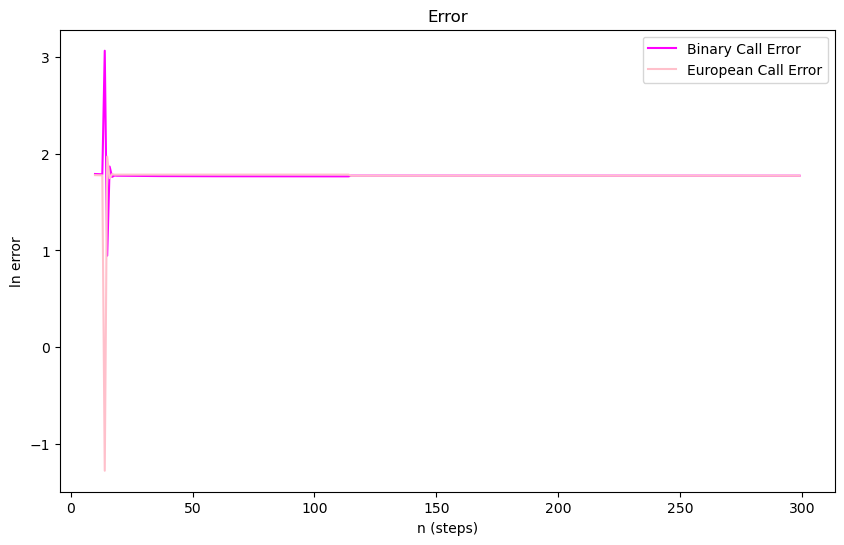

In [108]:
# create empty lists to store errors

step = np.arange(10, 300)
binary = []
euro = []
eurocall = EuropeanOption (1, 105, PayoffType.Call)
binarycall = EuropeanOption (1, 105, PayoffType.BinaryCall)

for n in step:
    eurocall_price = trinomialPricerAnchor(S, r, q, vol, eurocall, n, K)
    binarycall_price = trinomialPricerAnchor(S, r, q, vol, binarycall, n, K)
    binary.append(eurocall_price)
    euro.append(binarycall_price)

euro = np.array(euro)
binary = np.array(binary)
error_b = np.log(np.abs(binary - binarycall_price))
error_e = np.log(np.abs(euro - eurocall_price))


plt.figure(figsize = (10,6))
plt.plot(step, error_b, color='magenta', label = 'Binary Call Error')
plt.plot(step, error_e, color='pink', label = 'European Call Error')
plt.title('Error')
plt.xlabel('n (steps)')
plt.ylabel('ln error')
plt.legend()
plt.show()

#### Exercise 2.

Assuming forward delta convention, implement below function ```strikeFromdelta``` that calculates the strike from a given delta. Test with below:

S, r, q, T, vol, delta, payoffType = 100, 0.1, 0, 1, 0.1, 0.25, PayoffType.Put

In [48]:
europut = EuropeanOption (1, 105, PayoffType.Put)

In [49]:
def fwdDelta(fwd, stdev, strike, payoffType):
    d1 = math.log(fwd / strike) / stdev + stdev / 2 #ln(Ft/K)/sigma + sigma
    if payoffType == PayoffType.Call:
        return cnorm(d1)
    elif payoffType == PayoffType.Put:
        return -cnorm(-d1)
    else:
        raise Exception("not supported payoff type", payoffType)

# solve for the K such that Delta(S, T, K, vol) = delta, assuming forward delta convention
def strikeFromDelta(S, r, q, T, vol, delta, payoffType):
    strike = 0
    if payoffType == PayoffType.Call:
        delta = delta
    if payoffType == PayoffType.Put:
        delta = -delta
    stdev = vol * math.sqrt(T)
    fwd = S * math.exp((r-q)*T) # our forward price
    f = lambda K: (fwdDelta(fwd, stdev, K, payoffType) - delta) # for each strike, calc with our given delta
    a, b = 0.0001, 500
    strike = optimize.brentq(f, a, b) # use brent method for root search
    return strike

In [50]:
strikeFromDelta(100, 0.1, 0, 1, 0.1, 0.25, PayoffType.Put)

103.82649731801594

#### Exercise 3.

Implement ```smilefromMarks``` function below, it take the time to maturity $T$, current stop price $S$, risk free and dividend rate $r$ and $q$,
ATM volatility, BF25, RR25, BF10, RR10 quotes, returns a CubicSpline interpolated smile for this pillar. We assume ATM forward convention. 

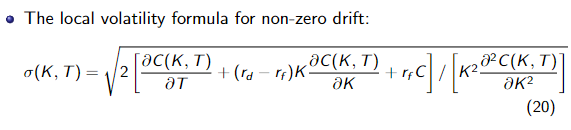

In [90]:
class ImpliedVol:
    def __init__(self, ts, smiles):
        self.ts = ts
        self.smiles = smiles
    # linear interpolation in variance, along the strike line
    def Vol(self, t, k): # looking for vol using bisection method
        # locate the interval t is in
        pos = bisect.bisect_left(self.ts, t)
        # if t is on or in front of first pillar,
        if pos == 0:
            return self.smiles[0].Vol(k)
        if pos >= len(self.ts):
            return self.smiles[-1].Vol(k)
        else:  # in between two brackets
            prevVol, prevT = self.smiles[pos-1].Vol(k), self.ts[pos-1]
            nextVol, nextT = self.smiles[pos].Vol(k), self.ts[pos]
            w = (nextT - t) / (nextT - prevT)
            prevVar = prevVol * prevVol * prevT
            nextVar = nextVol * nextVol * nextT
            return  math.sqrt((w * prevVar + (1-w) * nextVar)/t)
        return
    def dVoldK(self, t, k): # partial deriv of vol in respect to strike
        return (self.Vol(t, k+0.01) - self.Vol(t, k-0.01)) / 0.02
    def dVoldT(self, t, k): # partial deriv of vol in respect to time
        return (self.Vol(t+0.005, k) - self.Vol(t, k)) / 0.005
    def dVol2dK2(self, t, k): # partial second deriv in respect to strike squared
        return (self.Vol(t, k+0.01) + self.Vol(t, k-0.01) - 2*self.Vol(t, k)) / 0.0001

Plot the test implied volatility surface using below test functions.

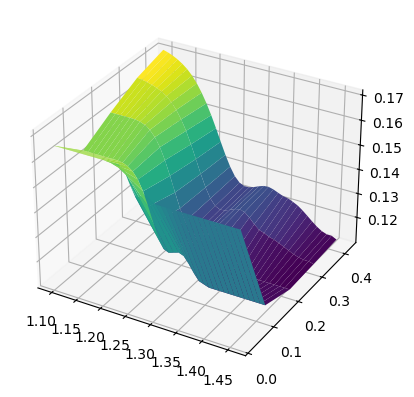

In [91]:
def createTestImpliedVol(S, r, q):
    pillars = [0.02, 0.04, 0.06, 0.08, 0.16, 0.25, 0.75, 1.0, 1.5, 2, 3, 5] # in year
    atmvols = [0.155, 0.1395, 0.1304, 0.1280, 0.1230, 0.1230, 0.1265, 0.1290, 0.1313, 0.1318, 0.1313, 0.1305, 0.1295]
    bf25s = [0.0016, 0.0016, 0.0021, 0.0028, 0.0034, 0.0043, 0.0055, 0.0058, 0.0060, 0.0055, 0.0054, 0.0050, 0.0045, 0.0043]
    rr25s = [-0.0065, -0.0110, -0.0143, -0.0180, -0.0238, -0.0288, -0.0331, -0.0344, -0.0349, -0.0340, -0.0335, -0.0330, -0.0330]
    bf10s = [0.0050, 0.0050, 0.0067, 0.0088, 0.0111, 0.0144, 0.0190, 0.0201, 0.0204, 0.0190, 0.0186, 0.0172, 0.0155, 0.0148]
    rr10s = [-0.0111, -0.0187, -0.0248, -0.0315, -0.0439, -0.0518, -0.0627, -0.0652, -0.0662, -0.0646, -0.0636, -0.0627, -0.0627]
    smiles = [smileFromMarks(pillars[i], S, r, q, atmvols[i], bf25s[i], rr25s[i], bf10s[i], rr10s[i]) for i in range(len(pillars))]
    return ImpliedVol(pillars, smiles)

def plotTestImpliedVolSurface():
    S, r, q = 1.25805, 0.01, 0.003
    iv = createTestImpliedVol(S, r, q)
    tStart, tEnd = 0.02, 0.5
    ts = np.arange(tStart, tEnd, 0.1)
    fwdEnd = S*math.exp((r-q)*tEnd)
    kmin = strikeFromDelta(S, r, q, tEnd, iv.Vol(tEnd, fwdEnd), 0.05, PayoffType.Put)
    kmax = strikeFromDelta(S, r, q, tEnd, iv.Vol(tEnd, fwdEnd), 0.05, PayoffType.Call)
    ks = np.arange(kmin, kmax, 0.01)

    vs = np.ndarray((len(ts), len(ks)))
    for i in range(len(ts)):
        for j in range(len(ks)):
            vs[i, j] = iv.Vol(ts[i], ks[j])
    hf = plt.figure()
    ha = hf.add_subplot(111, projection='3d')
    X, Y = np.meshgrid(ks, ts)
    ha.plot_surface(X, Y, vs, cmap='viridis')
    plt.show()
plotTestImpliedVolSurface()